In [1]:
%load_ext autoreload
%autoreload 2

# core

> Core utility functions for yolo and bacteria images with bounding boxes.

In [2]:
#| default_exp core

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.patches as patches
import os, cv2, nd2
from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm import tqdm

import torch, torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader

import fastcore.all as fc
from minai import *

In [5]:
#| export
plt.rcParams['image.cmap'] = 'gray'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

## Image processing

### Bacteria image

We have videos of bacteria. However, let's work with images with bounding boxes first. We save first frame as images. Something was wrong with `20mins021.nd2` file, so we won't use it. 

In [6]:
video_path = Path.home()/'data/pili/training_videos'
video_path.ls()

(#9) [Path('/home/kappa/data/pili/training_videos/200ms-0.4%-005.nd2'),Path('/home/kappa/data/pili/training_videos/0N01002.nd2'),Path('/home/kappa/data/pili/training_videos/7.1- 003.nd2'),Path('/home/kappa/data/pili/training_videos/0.1%.004.nd2'),Path('/home/kappa/data/pili/training_videos/1hr01002.nd2'),Path('/home/kappa/data/pili/training_videos/dCpdA R1 FH 017.nd2'),Path('/home/kappa/data/pili/training_videos/4hrs incu004.nd2'),Path('/home/kappa/data/pili/training_videos/WT-A86C-LB-ice-002.nd2'),Path('/home/kappa/data/pili/training_videos/Chp B Replicate 2 200 MS060.nd2')]

Let's take a look at an image of the first video.

In [7]:
vp = video_path.ls()[0]
vp

Path('/home/kappa/data/pili/training_videos/200ms-0.4%-005.nd2')

For each video, we want to only use the first frame for now. This is what it looks like:

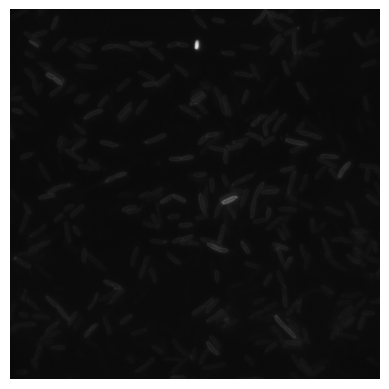

In [8]:
with nd2.ND2File(vp) as nd2_file:
    first_frame = nd2_file.read_frame(0)
    plt.imshow(first_frame)
    plt.axis('off') 

Now we turn the video into an image.

In [9]:
def save_first_frame(input_path, output_path, extension = '.png') -> None:
    """
    Save the first frame of an ND2 file as an image, using the same name as input file.
    """
    filename = input_path.name.removesuffix('.nd2')  # Some names have . in the filename
    output_path = (output_path/f'{filename}{extension}')
    Image.fromarray(nd2.imread(input_path)[0]).save(output_path)

In [10]:
# Save videos as images
# for p in video_path.ls(): 
#     if p.suffix == '.nd2': save_first_frame(p, path)

In [11]:
path = Path.home()/'data/pili/training_data'
path.ls()

(#18) [Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.png'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.png'),Path('/home/kappa/data/pili/training_data/1hr01002.csv'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.png'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.png'),Path('/home/kappa/data/pili/training_data/4hrs incu004.csv'),Path('/home/kappa/data/pili/training_data/7.1- 003.png'),Path('/home/kappa/data/pili/training_data/4hrs incu004.png'),Path('/home/kappa/data/pili/training_data/200ms-0.4%-005.csv'),Path('/home/kappa/data/pili/training_data/WT-A86C-LB-ice-002.csv'),Path('/home/kappa/data/pili/training_data/0.1%.004.png'),Path('/home/kappa/data/pili/training_data/dCpdA R1 FH 017.csv'),Path('/home/kappa/data/pili/training_data/0N01002.csv'),Path('/home/kappa/data/pili/training_data/0N01002.png'),Path('/home/kappa/data/pili/training_data/Chp B Replicate 2 200 MS060.csv'),Path('/home/kappa/data/pili/training_data/7.1- 0

We can now use `show_image` to display images.

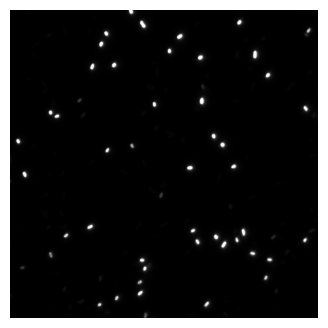

In [12]:
img_path = path/'0N01002.png'
bac_im = np.array(Image.open(img_path))
show_image(bac_im, figsize=(4,4));

Now, we want to take care of bounding boxes. We first turn them into YOLO bounding box format because they are in angle format.

YOLO bounding box format:
```
'class_index', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'
```
where `x1`, ..., `y4` are edge points for each box.

csv files have information about the box. `Length`, `Width`, `Position X` and `Position Y` are in nanometer(?).

In [13]:
df = pd.read_csv(path/'0N01002.csv')
df.head()

,Name,Length,Width,Angle,Position X,Position Y,Color R,Color G,Color B,Type
0,Box 1,2.100000e-06,0.000001,0.733038,0.000011,0.000082,0.509804,0.901961,0.509804,1
1,Box 2,2.300000e-06,0.000001,0.401426,0.000015,0.000083,0.509804,0.901961,0.509804,1
2,Box 3,2.000000e-06,0.000001,0.837758,0.000013,0.000072,0.509804,0.901961,0.509804,1
3,Box 4,2.100000e-06,0.000001,1.832596,0.000029,0.000075,0.509804,0.901961,0.509804,1
4,Box 5,9.000000e-07,0.000001,-1.553343,0.000026,0.000084,1.000000,0.000000,0.549020,6


TODO: make `class_index` 0-based.

In [14]:
#| export
def calc_corners(csv, max_pos = 8.458666666666666e-05):
    df = pd.read_csv(csv)
    results = []
    for _, row in df.iterrows():
        length = row['Length']
        width = row['Width']
        angle = row['Angle']
        pos_x = row['Position X']
        pos_y = row['Position Y']

        x1 = pos_x + length/2 * np.cos(angle) - width/2 * np.sin(angle)
        y1 = pos_y + length/2 * np.sin(angle) + width/2 * np.cos(angle)
        x2 = pos_x - length/2 * np.cos(angle) - width/2 * np.sin(angle)
        y2 = pos_y - length/2 * np.sin(angle) + width/2 * np.cos(angle)
        x3 = pos_x - length/2 * np.cos(angle) + width/2 * np.sin(angle)
        y3 = pos_y - length/2 * np.sin(angle) - width/2 * np.cos(angle)
        x4 = pos_x + length/2 * np.cos(angle) + width/2 * np.sin(angle)
        y4 = pos_y + length/2 * np.sin(angle) - width/2 * np.cos(angle)
        results.append([row['Type'], x1, y1, x2, y2, x3, y3, x4, y4])

    df = pd.DataFrame(results, columns=['class_index', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
    df = pd.concat([df.iloc[:, 0], df.iloc[:, 1:] / max_pos], axis=1)
    return torch.tensor(df.to_numpy())

In [15]:
y = calc_corners(path/'0N01002.csv')
y[:5]

tensor([[1.0000, 0.1295, 0.9836, 0.1110, 0.9670, 0.1205, 0.9565, 0.1390, 0.9731],
        [1.0000, 0.1901, 0.9989, 0.1651, 0.9883, 0.1706, 0.9752, 0.1957, 0.9859],
        [1.0000, 0.1547, 0.8677, 0.1389, 0.8501, 0.1494, 0.8406, 0.1652, 0.8582],
        [1.0000, 0.3313, 0.8914, 0.3377, 0.8674, 0.3514, 0.8710, 0.3450, 0.8950],
        [6.0000, 0.3144, 0.9890, 0.3142, 0.9996, 0.3000, 0.9994, 0.3002, 0.9887]],
       dtype=torch.float64)

We want to take a look at images with bounding boxes.

In [16]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_bac_img_with_boxes(im, boxes, figsize=(8,8), title=None, ax=None, legend=None, legend_loc='upper left', **kwargs):
    """Display image with bounding boxes for different cell types, returns fig and ax for further customization"""
    colors = dict([(1, 'red'), (2, 'blue'), (3, 'green'), (4, 'yellow'), (5, 'purple'), (6, 'orange')])
    class_names = dict([(1, 'Type 1 - Both poles free'), (2, 'Type 2 - One pole occluded'), 
                        (3, 'Type 3 - Both poles occluded'), (4, 'Type 4 - Super bright cell'), 
                        (5, 'Type 5 - Very dim cell'), (6, 'Type 6 - Partial cell')])
    height, width = im.shape[:2]

    ax = show_image(im, ax=ax, figsize=figsize, title=title, **kwargs)

    unique_classes = boxes[:,0].unique().int().tolist()
    legend_elements = [patches.Patch(facecolor='none', edgecolor=colors[class_idx], label=class_names[class_idx])
                      for class_idx in unique_classes]

    for box in boxes:
        class_idx = box[0].item()
        corners = [[box[1].item() * width, box[2].item() * height],
                  [box[3].item() * width, box[4].item() * height],
                  [box[5].item() * width, box[6].item() * height],
                  [box[7].item() * width, box[8].item() * height]]

        color = colors.get(box[0].item(), 'white')
        polygon = patches.Polygon(corners, fill=False, edgecolor=color, linewidth=1)
        ax.add_patch(polygon)

    if legend: ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=legend_loc)
    plt.tight_layout()
    return ax

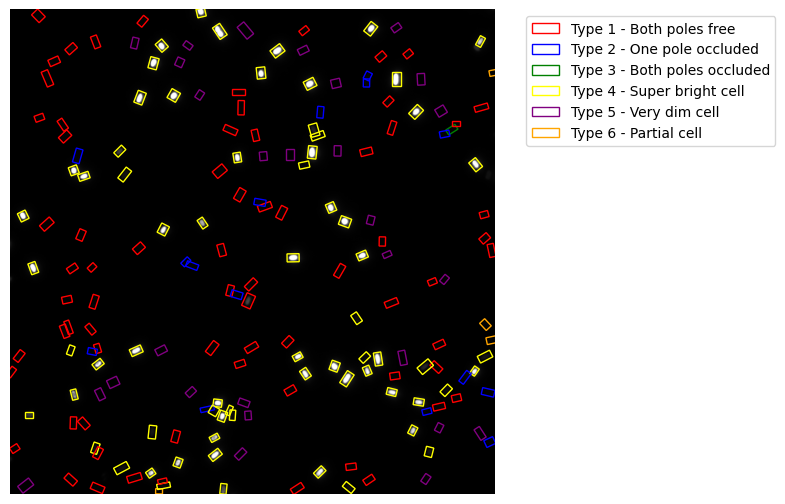

In [17]:
show_bac_img_with_boxes(bac_im, y, legend=True, legend_loc='best');

### VOC image

We will also work with [PASCAL VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/index.html). 

In [18]:
voc_img_path = Path('../data/images')
voc_img_path

Path('../data/images')

In [19]:
df = pd.read_csv("../8examples.csv")
df

,img,label
0,000007.jpg,000007.txt
1,000009.jpg,000009.txt
2,000016.jpg,000016.txt
3,000019.jpg,000019.txt
4,000020.jpg,000020.txt
5,000021.jpg,000021.txt
6,000122.jpg,000122.txt
7,000129.jpg,000129.txt


In [20]:
df.iloc[3]

img      000019.jpg
label    000019.txt
Name: 3, dtype: object

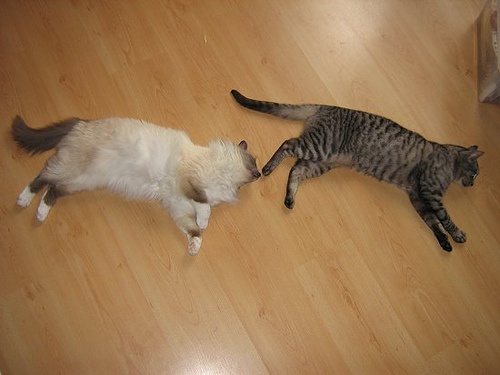

In [21]:
voc_im = Image.open(voc_img_path/df.iloc[3,0])
voc_im

In [22]:
voc_lbl_path = Path('../data/labels')
voc_lbl_path

Path('../data/labels')

In [23]:
with open(voc_lbl_path/df.iloc[3,1]) as f:
    for label in f.readlines():
        print(label)

7 0.712 0.45599999999999996 0.504 0.448

7 0.275 0.4933333333333333 0.51 0.3893333333333333



In [32]:
def get_boxes(file):
    boxes = []
    with open(file) as f:
        for label in f.readlines():
            parts = label.strip().split()
            class_label = int(float(parts[0])) if float(parts[0]).is_integer() else float(parts[0])
            x, y, width, height = [float(p) for p in parts[1:5]]
            boxes.append([class_label, x, y, width, height])
    return torch.tensor(boxes)

In [33]:
boxes = get_boxes(voc_lbl_path/df.iloc[3,1])
boxes

tensor([[7.0000, 0.7120, 0.4560, 0.5040, 0.4480],
        [7.0000, 0.2750, 0.4933, 0.5100, 0.3893]])

In [26]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    if len(im.shape)==3 and im.shape[0]<5: im=im.transpose(1,2,0)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im)

    # boxes is a tensor, which is in cellboxes format
    if not isinstance(boxes, list):
        boxes = cellboxes_to_boxes(boxes.unsqueeze(0))[0]
        
    # box format is [x_mid, y_mid, width, height]
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()

In [27]:
VOC_CLASSES = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", 
           "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
           "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [34]:
@fc.delegates(show_image)
def show_voc_image_with_boxes(im, boxes, ax=None, figsize=(12,12), box_color='red', thickness=2, **kwargs):
    "Show image with bounding boxes with `[class_id, x_center, y_center, width, height]` format."
    ax = show_image(im, ax=ax, figsize=figsize, **kwargs)
    h, w = im.shape[:2] if isinstance(im, np.ndarray) else im.height, im.width
    
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        x1, y1 = int((x_center - width/2) * w), int((y_center - height/2) * h)
        x2, y2 = int((x_center + width/2) * w), int((y_center + height/2) * h)
        
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=thickness, edgecolor=box_color, facecolor='none')
        ax.add_patch(rect)
        
        ax.text(x1, y1-5, f"{VOC_CLASSES[int(class_id)]}", color=box_color)
    
    return ax

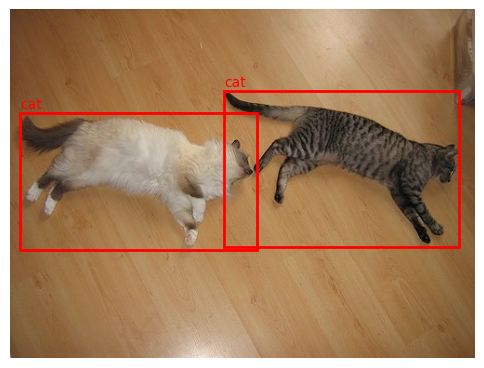

In [35]:
show_voc_image_with_boxes(voc_im, boxes, figsize=(6,6));

In [39]:
boxes.shape, boxes

(torch.Size([2, 5]),
 tensor([[7.0000, 0.7120, 0.4560, 0.5040, 0.4480],
         [7.0000, 0.2750, 0.4933, 0.5100, 0.3893]]))

In [40]:
y.shape, y

(torch.Size([187, 9]),
 tensor([[1.0000, 0.1295, 0.9836,  ..., 0.9565, 0.1390, 0.9731],
         [1.0000, 0.1901, 0.9989,  ..., 0.9752, 0.1957, 0.9859],
         [1.0000, 0.1547, 0.8677,  ..., 0.8406, 0.1652, 0.8582],
         ...,
         [4.0000, 0.4325, 0.8251,  ..., 0.8316, 0.4172, 0.8162],
         [4.0000, 0.4523, 0.8385,  ..., 0.8163, 0.4605, 0.8202],
         [4.0000, 0.4639, 0.8483,  ..., 0.8263, 0.4654, 0.8271]],
        dtype=torch.float64))

In [44]:
def show_with_boxes(im, boxes, **kwargs):
    if boxes.shape[1] == 5:
        return show_voc_image_with_boxes(im, boxes, **kwargs)
    else:
        return show_bac_img_with_boxes(im, boxes, **kwargs)

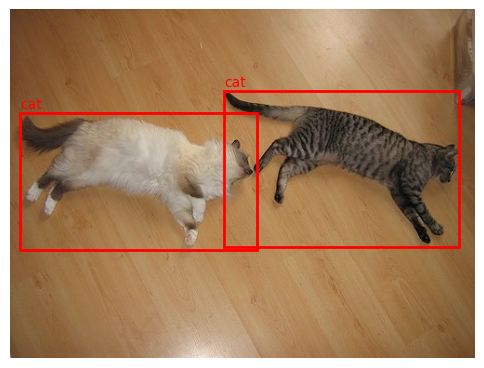

In [50]:
show_with_boxes(voc_im, boxes, figsize=(6,6));

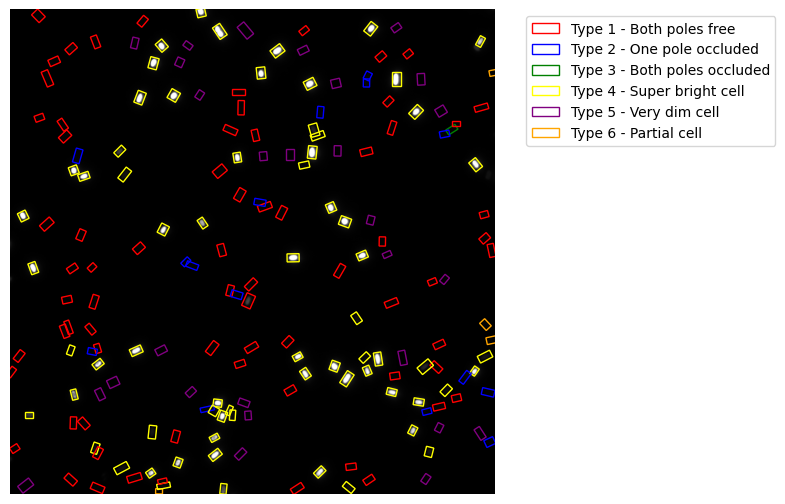

In [51]:
show_with_boxes(bac_im, y, legend=True, legend_loc='best');

In [19]:
#| export
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [20]:
#| export
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [21]:
#| export
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    if len(im.shape)==3 and im.shape[0]<5: im=im.transpose(1,2,0)
    height, width, _ = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im)

    # boxes is a tensor, which is in cellboxes format
    if not isinstance(boxes, list):
        boxes = cellboxes_to_boxes(boxes.unsqueeze(0))[0]
        
    # box format is [x_mid, y_mid, width, height]
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()

In [22]:
#| export
@fc.delegates(plt.Axes.imshow)
def plot_boxes(im, boxes, figsize=(8,8), ax=None, legend=None, bformat=None, **kwargs):
    "Plot boxes on image with automatic format detection"
    if bformat=='v1': 
        return plot_image(im, boxes)
    return imshow_with_boxes(im, boxes, figsize=figsize, ax=ax, legend=legend, **kwargs)

<Figure size 800x800 with 0 Axes>

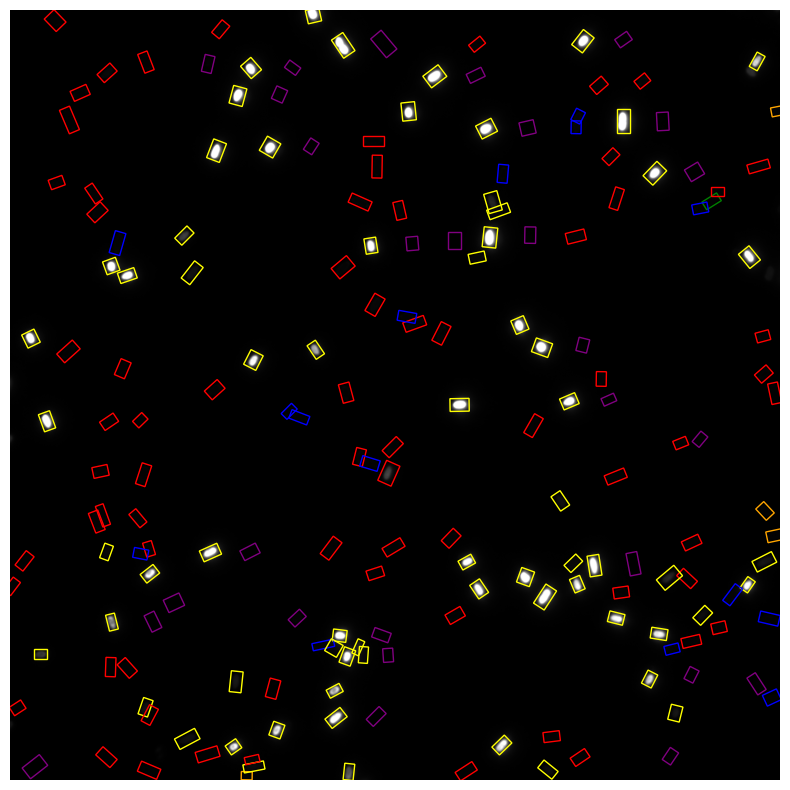

In [23]:
plot_boxes(im, y);

## Image transform

### CLAHE

Tackling low signal problem: Let's take a look at an image with labels.

How CLAHE (Contrast Limited Adaptive Histogram Equalization) works:

1. Basic Principle:
- Unlike regular histogram equalization which works on the entire image at once, CLAHE works on small regions (tiles) of the image
- This local approach helps maintain local details and contrast

2. Step-by-Step Process:
   - The image is divided into small tiles (defined by tile_grid_size)
   - For each tile:
     - A local histogram is computed
     - The histogram is clipped at a predetermined value (clip_limit) to prevent noise amplification
     - Histogram equalization is applied to that tile
   - Bilinear interpolation is used to eliminate artificial boundaries between tiles

3. Key Advantages:
   - Better handling of local contrast
   - Prevents over-amplification of noise (through clipping)
   - Preserves edges and local details
   - Works well with varying brightness levels in different image regions

4. Parameters Impact:
   - clip_limit: Higher values allow more contrast enhancement but may increase noise
   - tile_grid_size: Smaller tiles give more local enhancement but might make the image look "patchy"

In [24]:
im.shape

(1952, 1952)

TODO: Why are we using `uint16`? Maybe should change it to float32 or bfloat16?

In [25]:
im.dtype

dtype('uint16')

In [26]:
#| export
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)
    return enhanced

In [27]:
#| export
def compare_ims(img1, img2, im1_title='img1', im2_title='img2', cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img1, cmap=cmap)
    plt.title(im1_title)
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(img2, cmap=cmap)
    plt.title(im2_title)
    plt.axis('off')

    plt.show()

In [28]:
#| export
def compare_ims_with_boxes(img1, img2, boxes1=None, boxes2=None, im1_title='img1', im2_title='img2', 
                           legend=None, legend_loc='best', bformat=None, **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    
    if boxes1 is not None: 
        plot_boxes(img1, boxes1, ax=axs[0], legend=legend, legend_loc=legend_loc, bformat=bformat, **kwargs)
    else:
        axs[0].imshow(img1, cmap='gray')
        axs[0].axis('off')
    axs[0].set_title(im1_title)
    
    if boxes2 is not None:
        plot_boxes(img2, boxes2, ax=axs[1], legend=legend, legend_loc=legend_loc, bformat=bformat, **kwargs)
    else:
        axs[1].imshow(img2, cmap='gray')
        axs[1].axis('off')
    axs[1].set_title(im2_title)
    
    plt.tight_layout()
    plt.show()
    return fig, axs

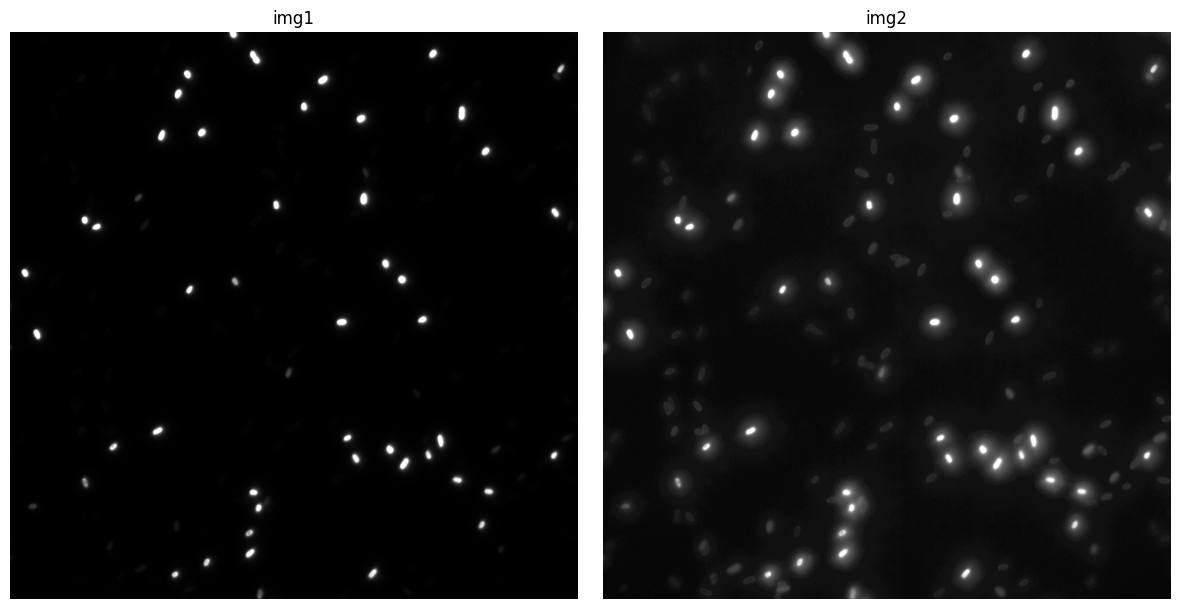

In [29]:
enh = apply_clahe(im, clip_limit=10.1, tile_grid_size=(8,8))
compare_ims_with_boxes(im, enh);

Here's what it looks like with labels:

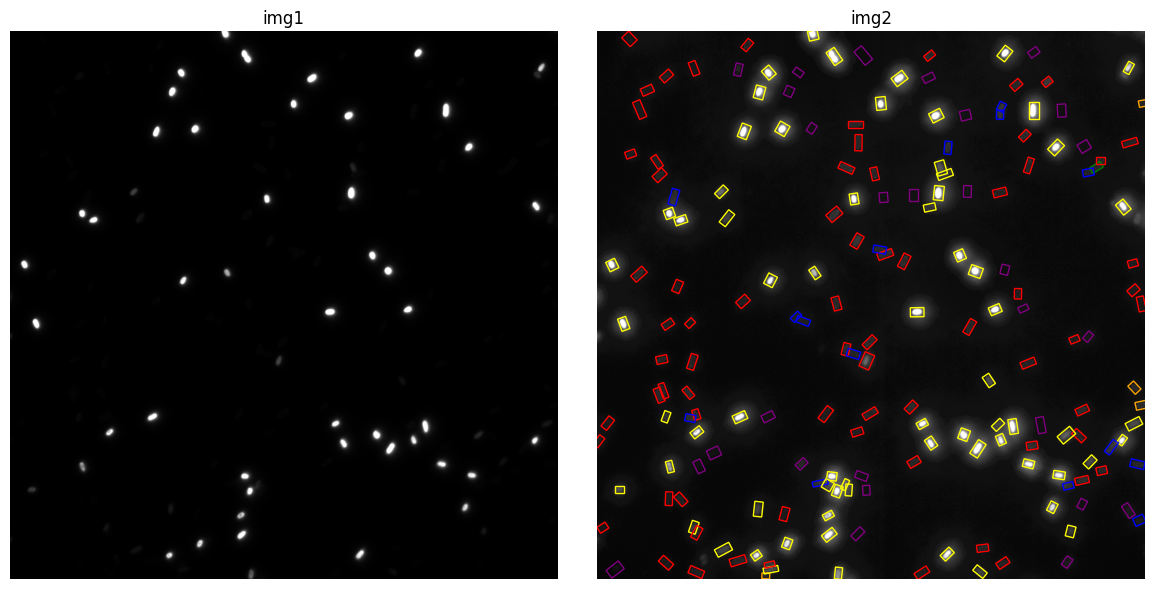

In [30]:
compare_ims_with_boxes(im, enh, boxes2=y);

In [32]:
#| hide
import nbdev; nbdev.nbdev_export()